# Preprocess

Using TensorFlow backend.


(704, 13)
(704,)
(161, 13)
(161,)


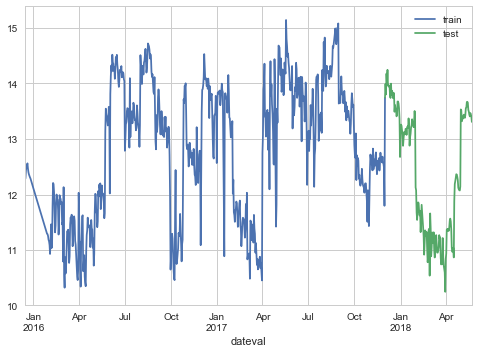

In [1]:
import keras
import pandas as pd
import pandasql as ps
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pandas import DataFrame
from sklearn.model_selection import TimeSeriesSplit
from typing import Set, Any
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
np.seterr(divide='ignore', invalid='ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential # Tells you which is the backend used (i.e. Tensorflow)
from keras.layers import Dense  # The same Keras code is used for each backend.
from keras.optimizers import Adam, SGD

df = pd.read_csv("data/data.csv")
df = ps.sqldf("""select * from df order by dateval asc""")
df = df[["dateval", "log_y"]]
df["dateval"] = pd.to_datetime(df["dateval"])
df = df.set_index("dateval")

df['log_y_tomorrow'] = df['log_y'].shift(-1)
df = df.dropna()

df = df.iloc[0:890]
split_date = pd.Timestamp("2017-12-01")

train = df.loc[:split_date, ['log_y']]
test = df.loc[split_date:, ['log_y']]

ax = train['log_y'].plot()
test['log_y'].plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

for column in train.columns:
    train[[column]] = sc.fit_transform(train[[column]])
    test[[column]] = sc.transform(test[[column]])

train['tomorrow_log_y'] = train['log_y'].shift(-1)    
test['tomorrow_log_y'] = test['log_y'].shift(-1)    

for s in range(1, 13):
    train['log_y_lag_{}'.format(s)] = train['log_y'].shift(s)
    test['log_y_lag_{}'.format(s)] = test['log_y'].shift(s)

train = train.dropna()
test = test.dropna()

X_train = train.drop("tomorrow_log_y", axis=1).values
y_train = train['tomorrow_log_y'].values

X_test = test.drop("tomorrow_log_y", axis=1).values
y_test = test['tomorrow_log_y'].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

features = X_train.shape[1]

# Train

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 2
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))
/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 2
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


dict_keys(['val_loss', 'loss'])


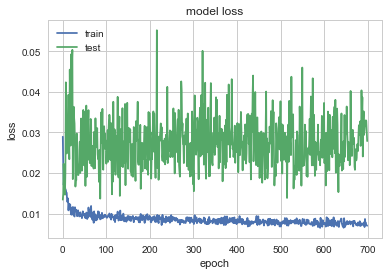

In [3]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import Dropout

K.clear_session()

model = Sequential()
model.add(Dropout(0.2, input_shape=(features,)))
model.add(Dense(36, input_dim=features, activation='relu'))
model.add(Dense(18, input_dim=features, activation='relu'))
model.add(Dense(9, input_dim=features, activation='relu'))
model.add(Dense(4, input_dim=features, activation='relu'))
model.add(Dense(2, input_dim=features, activation='relu'))
model.add(Dense(1)) # 1 output
model.compile(loss='mean_squared_error', optimizer='adam', lr= 0.005, momentum=0.9)
history = model.fit(X_train, y_train, epochs=700, validation_split=0.33, 
          batch_size=3, verbose=0)
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate

/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 2
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


root mean squared error = 0.11366520682228273
model % off = 0.2843465522182438
baseline % off = 0.5578613644818934
% better than baseline = 0.4902917277981296


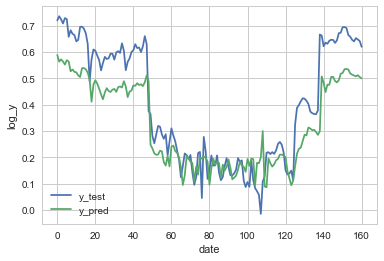

In [4]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from math import sqrt
y_test_mean = y_test.mean()
baseline = np.zeros(len(y_test))
baseline.fill(y_test_mean)


rmse = sqrt(mean_squared_error(y_test, y_pred))
model_pct_off = rmse / y_test_mean
baseline_pct_off = sqrt(mean_squared_error(y_test, baseline)) / y_test_mean
pct_improvement_over_baseline = (model_pct_off/baseline_pct_off - 1)*-1
print("root mean squared error = {}".format(rmse))
print("model % off = {}".format(model_pct_off))
print("baseline % off = {}".format(baseline_pct_off))
print("% better than baseline = {}".format(pct_improvement_over_baseline))
plt.plot(y_test)
plt.plot(y_pred)
plt.ylabel('log_y')
plt.xlabel('date')
plt.legend(['y_test', 'y_pred'], loc='lower left')
plt.show()